# Benchmark Data Sets in Exam Timetabling
Data -> __[University of Toronto Benchmark Data](http://www.cs.nott.ac.uk/~pszrq/data.htm)__

**Problem Description :**
... A Conflict Matrix C was defined where each element Cij = 1 if exam i conflict with exam j (have common students), or Cij = 0 otherwise. The Conflict Density represents the ratio between the number of elements of value "1" to the total number of elements in the conflict matrix.

**Objective :**
1. to minimise the number of timeslots needed for the problem (graph coloring)
2. to minimise the sum of approximate costs per student. i.e. Zigma wi/S, i = 0, 1, 2, 3, 4.

**LIST TO DO**
- [x] Import Data
- [x] Build Conflict Matrix
- [x] Make TIme Table (initial solution)
- [x] Hill Climbing
- [x] Simulated Annealing

In [1]:
# Import Library
import pandas as pd
import numpy as np
import random
import math
import copy
import timeit
import matplotlib.pyplot as plt
plt.style.use('classic')
plt.figure(figsize=(14,10))
%matplotlib inline

#buat plot grafik biar okh dapat A xD
#import plotly.graph_objects as go

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# pd.reset_option('^display.', silent=True)

In [2]:
print('1. Carleton91, ts = 35, global-optimum = 4.42')
print('2. Carleton92, ts = 32, global-optimum = 3.74')
print('3. EarlHaig83, ts = 24, global-optimum = 33.71')
print('4. EdHEC92, ts = 18, global-optimum = 10.08')
print('5. KingFahd93, ts = 20, global-optimum = 12.96')
print('6. LSE91, ts = 18, global-optimum = 10.54')
print('7. Rye-f-92, ts = 23, global-optimum = 8.53')
print('8. St.Andrews83, ts = 13, global-optimum = 157.03')
print('9. TorontoAS92, ts = 35, global-optimum = 3.27')
print('10. TorontoE92, ts = 10, global-optimum = 25.39')
print('11. Trent92, ts = 23, global-optimum = 7.75')
print('12. YorkMills83, ts = 21, global-optimum = 34.84')
print('13. Pur-s-93, ts = 42, global-optimum = 3.9')

userinput = input('Choose the problem')

if userinput == '1':
    dataset = 'car-s-91'
    t = 35
    global_optimum = 4.42
    hc_cost = 9.79
elif userinput == '2':
    dataset = 'car-f-92'
    t = 32
    global_optimum = 3.74
    hc_cost = 8.99
elif userinput == '3':
    dataset = 'ear-f-83'
    t = 24
    global_optimum = 33.71
    hc_cost = 50.88
elif userinput == '4':
    dataset = 'hec-s-92'
    t = 18
    global_optimum = 10.08
    hc_cost = 21.34
elif userinput == '5':
    dataset = 'kfu-s-93'
    t = 20
    global_optimum = 12.96
    hc_cost = 19.81
elif userinput == '6':
    dataset = 'lse-f-91'
    t = 18
    global_optimum = 10.54
    hc_cost = 19.38
elif userinput == '7':
    dataset = 'rye-s-93'
    t = 23
    global_optimum = 8.53
    hc_cost = 23.08
elif userinput == '8':
    dataset = 'sta-f-83'
    t = 13
    global_optimum = 157.03
    hc_cost = 171.56
elif userinput == '9':
    dataset = 'uta-s-92'
    t = 35
    global_optimum = 3.27
    hc_cost = 6.45
elif userinput == '10':
    dataset = 'ute-s-92'
    t = 10
    global_optimum = 25.39
    hc_cost = 36.368
elif userinput == '11':
    dataset = 'tre-s-92'
    t = 23
    global_optimum = 7.75
    hc_cost = 11.77
elif userinput == '12':
    dataset = 'yor-f-83'
    t = 21
    global_optimum = 34.84
    hc_cost = 54.64
elif userinput == '13':
    dataset = 'pur-s-93'
    t = 42
    global_optimum = 3.9
    hc_cost = 14.28
else:
    print('Forbidden, choose 1-13')

1. Carleton91, ts = 35, global-optimum = 4.42
2. Carleton92, ts = 32, global-optimum = 3.74
3. EarlHaig83, ts = 24, global-optimum = 33.71
4. EdHEC92, ts = 18, global-optimum = 10.08
5. KingFahd93, ts = 20, global-optimum = 12.96
6. LSE91, ts = 18, global-optimum = 10.54
7. Rye-f-92, ts = 23, global-optimum = 8.53
8. St.Andrews83, ts = 13, global-optimum = 157.03
9. TorontoAS92, ts = 35, global-optimum = 3.27
10. TorontoE92, ts = 10, global-optimum = 25.39
11. Trent92, ts = 23, global-optimum = 7.75
12. YorkMills83, ts = 21, global-optimum = 34.84
13. Pur-s-93, ts = 42, global-optimum = 3.9
Choose the problem4


In [3]:
# Import Data

# start_time = timeit.default_timer()
course_path = "D:/Dataset/okh1/{}.crs".format(dataset)
student_path = "D:/Dataset/okh1/{}.stu".format(dataset)
que_s = []
que_iteration = []
que_timecost = []

In [4]:
def create_matrix(stu_file, crs_file):
    global m, n
    m = 0
    n = 0
    for line in open(stu_file,"r"):
        m+=1    #count the number of students
    for line in open(crs_file,"r"):
        n+=1    #count the number of exams
    #store datas into stus[]
    stus = []
    fileHandle = open(stu_file, "r")
    new = []
    for i in range(m):
        everystu = fileHandle.readline().split(" ")
        for j in everystu:
            if(j=='\n'):
                continue
            new.append(int(j))
        stus.append(new)
        new = []
    #create cij
    cij = [[0 for col in range(n)] for row in range(n)]
    for row in range(m):
        for i in stus[row]:
            for j in stus[row]:
                cij[i-1][j-1]+=1
    return cij

def mark_hardest(exam_list, s_initial, cij):
    available_list = [0 for i in range(n)]
    minimun = 999
    location = 0
    for i in range(n):
        if exam_list[i]!=-1:
            continue
        for j in s_initial: 
            if j==[]: 
                available_list[i]+=1
                continue
            available = True
            for k in j: 
                if cij[i][k]!=0: 
                    available = False
                    break
            if available:
                available_list[i]+=1             
        if available_list[i]<minimun:
            minimun=available_list[i]
            location = i
    if minimun==0:
        location = -1
    return location

def check_feasibility(timetable, cij):
    for i in timetable:
        for j in i:
            for k in i:
                if j==k:
                    continue
                if cij[j][k]!=0:
                    return False
    return True

def check_feasibility_slot(timeslot, cij):
    for i in timeslot:
        for j in timeslot:
            if i==j:
                continue
            if cij[i][j]!=0:
                return False
    return True

def contact_score(timetable, cij, t1, t2, que1, que2):
    score = 0
    for i in que1:
        p = 16
        for x in range(5):
            t = t1-x-1
            if t<0:
                continue
            for j in timetable[t]:
                if cij[i][j] != 0:
                    score += cij[i][j]*p
            p = p/2
        p = 16
        for t in timetable[t1+1:t1+6]:
            for j in t:
                if cij[i][j] != 0:
                    score += cij[i][j]*p
            p = p/2
    for i in que2:
        p = 16
        for x in range(5):
            t = t2-x-1
            if t<0:
                continue
            for j in timetable[t]:
                if cij[i][j] != 0:
                    score += cij[i][j]*p
            p = p/2
        p = 16
        for t in timetable[t2+1:t2+6]:
            for j in t:
                if cij[i][j] != 0:
                    score += cij[i][j]*p
            p = p/2
    score = score/float(m)
    return score

def index_2d(myList, v):
    for i, x in enumerate(myList):
        if v in x:
            return i

# Ini untuk hill climbing biar cepat
def check_hard_constraint(initial_solution, course, index):
    check = True
    arr = degree_table.iloc[course, 1]
    exam = []
    for i in range(0, len(initial_solution)):
        if arr_time_table[i][1] == index:
            exam.append(i+1)
    if any(a in arr for a in exam):
        check = False
    return bool(check)
        
def evaluate(timetable, cij):
    timeslots = len(timetable)
    score = 0
    for i in range(timeslots):
        p = 16
        for j in timetable[i+1:i+6]:
            for x in timetable[i]:
                for y in j:
                    if cij[x][y] != 0:
                        score += cij[x][y]*p
            p = p/2
    score = score/float(m)
    return score

def evaluate_slot(timetable, cij):
    timetable = convert_tt(timetable)
    timeslots = len(timetable)
    score = 0
    for i in range(timeslots):
        p = 16
        for j in timetable[i+1:i+6]:
            for x in timetable[i]:
                for y in j:
                    if cij[x][y] != 0:
                        score += cij[x][y]*p
            p = p/2
    score = score/float(m)
    return score

def get_cost(initial_solution, course):
    cost = 0
    index_a = initial_solution[course][1]
    for i in range(0, n):
        if i == course:
            continue
        index_b = initial_solution[i][1]
        diff = abs(index_a - index_b)
        num = cij[i][course]
        if diff == 1:
            cost += 16*num
        elif diff == 2:
            cost += 8*num
        elif diff == 3:
            cost += 4*num
        elif diff == 4:
            cost += 2*num
        elif diff == 5:
            cost += 1*num
    return cost/m

def convert_tt(tt):
    time_table = []
    for i in range(0, t):
        time_table.append([])
    for i in range(0, len(tt)):
        time_table[tt[i][1]].append(tt[i][0])
    return time_table
    
# Code dibawah ini untuk Simulated Annealing
def ns1(s, cij):
#     move, choose a random exam then change its time slot to another random time slot
    timetable = copy.deepcopy(s)
    deviation = 0
    score_sa = 0
    course = random.randint(0, n-1)
    index = random.randint(0,t-1)
    course_index = index_2d(timetable, course)
    deviation -= evaluate(timetable, cij)
    timetable[course_index].remove(course)
    timetable[index].append(course)
    
    if check_feasibility_slot(timetable[index], cij):
        score_sa = evaluate(timetable, cij)
        deviation += score_sa
    else:
        deviation = 1000
    return timetable, score_sa, deviation
    
def ns2(s,cij):
#     swap, chose two random exams then swap their time slots

    timetable = copy.deepcopy(s)
    deviation = 0
    score_sa = 0
    course1 = random.randint(0, n-1)
    course2 = random.randint(0, n-1)
    arr1 = degree_table.iloc[course1, 1]
    arr2 = degree_table.iloc[course2, 1]
    while(course1 == course2):
        course2 = random.randint(0, n-1)
    course1_index = index_2d(timetable, course1)
    course2_index = index_2d(timetable, course2)
    deviation -= evaluate(timetable, cij)
    timetable[course1_index].remove(course1)
    timetable[course2_index].remove(course2)
    timetable[course1_index].append(course2)
    timetable[course2_index].append(course1)
    
    if check_feasibility_slot(timetable[course1_index], cij):
        if check_feasibility_slot(timetable[course2_index], cij):
            score_sa = evaluate(timetable, cij)
            deviation += score_sa
        else:
            deviation = 1000
    else:
        deviation = 1000
    
    return timetable, score_sa, deviation
    
def ns3(s, cij):
#     move-2, choose two random exams and move their time slots to any another time slot
    deviation = 0
    score_sa = 0
    timetable = copy.deepcopy(s)
    deviation -= evaluate(timetable, cij)
    timetable_new, x1, d_new = ns1(timetable, cij)
    timetable, x2, d = ns1(timetable_new, cij)
    if check_feasibility(timetable, cij):
        score_sa = evaluate(timetable, cij)
        deviation += score_sa
    else:
        deviation = 1000
    
    return timetable, score_sa, deviation
    
def ns4(s, cij):
#     swap-3, choose three random exams (i.e. a, b, c) 
#     and change the time slot of b to time slot of a, c to time slot of b, 
#     and a to time slot of c

    timetable = copy.deepcopy(s)
    deviation = 0
    score_sa = 0
    course1 = random.randint(0, n-1)
    course2 = random.randint(0, n-1)
    course3 = random.randint(0, n-1)
    arr1 = degree_table.iloc[course1, 1]
    arr2 = degree_table.iloc[course2, 1]
    arr3 = degree_table.iloc[course3, 1]
    
    while(course1 == course2 or course2 == course3 or course1 == course3):
        course2 = random.randint(0, n-1)
        course3 = random.randint(0, n-1)
    course1_index = index_2d(timetable, course1)
    course2_index = index_2d(timetable, course2)
    course3_index = index_2d(timetable, course3)

    deviation -= evaluate(timetable, cij)
    timetable[course1_index].remove(course1)
    timetable[course2_index].remove(course2)
    timetable[course3_index].remove(course3)
    
    timetable[course2_index].append(course1)
    timetable[course3_index].append(course2)
    timetable[course1_index].append(course3)
    
    if check_feasibility_slot(timetable[course1_index], cij):
        if check_feasibility_slot(timetable[course2_index], cij):
            if check_feasibility_slot(timetable[course3_index], cij):
                score_sa = evaluate(timetable, cij)
                deviation += score_sa
            else:
                deviation = 1000
        else:
            deviation = 1000
    else:
        deviation = 1000
    
    return timetable, score_sa, deviation
    
def ns5(s, cij):
#     move-3, similar with move-2 but with three exams instead.
    deviation = 0
    score_sa = 0
    timetable = copy.deepcopy(s)
    deviation -= evaluate(timetable, cij)
    timetable_1, x1, d_1= ns1(timetable, cij)
    timetable_2, x2, d_2= ns1(timetable_1, cij)
    timetable, x3, d = ns1(timetable_2, cij)
    if check_feasibility(timetable, cij):
        score_sa = evaluate(timetable, cij)
        deviation += score_sa
    else:
        deviation = 1000
    
    return timetable, score_sa, deviation 



def n1(s, cij):
    timetable = copy.deepcopy(s)
    deviation = 0
    t = len(timetable)
    t1 = random.randint(0,t-1)
    while timetable[t1] == []:
        t1 = random.randint(0,t-1)
    t2 = random.randint(0,t-1)
    while(t1 == t2):
        t2 = random.randint(0,t-1)
    que1 = []
    que2 = []
    p1 = 0
    p2 = 0
    e = random.choice(timetable[t1])
    que1.append(e)
    while(p1<len(que1) or p2<len(que2)):
        while(p1<len(que1)):
            for i in que1[p1:]:
                for j in timetable[t2]:
                    if cij[i][j] == 0:
                        continue
                    if j in que2:
                        continue
                    que2.append(j)
                p1 += 1
        while(p2<len(que2)):
            for i in que2[p2:]:
                for j in timetable[t1]:
                    if cij[i][j] == 0:
                        continue
                    if j in que1:
                        continue
                    que1.append(j)
                p2 += 1

    deviation -= contact_score(timetable,cij,t1,t2,que1,que2)
    
    for i in que1:
        timetable[t1].remove(i)
    for i in que2:
        timetable[t2].remove(i)
    timetable[t1].extend(que2)
    timetable[t2].extend(que1)
    score_sa = evaluate(timetable, cij)
    deviation += contact_score(timetable,cij,t2,t1,que1,que2)
    return timetable, score_sa, deviation

def n2(s, cij):
    timetable = copy.deepcopy(s)
    deviation = 0
    tlist = []
    for i in range(len(timetable)):
        tlist.append(i)
    random.shuffle(tlist)
    for t in tlist:
        if timetable[t] == []:
            continue
        elist = timetable[t][:]
        random.shuffle(elist)
        ttlist = tlist[:]
        ttlist.remove(t)
        random.shuffle(ttlist)
        for e1 in elist:
            conflict = False
            for tt in ttlist:
                for e2 in timetable[tt]:
                    if cij[e1][e2] != 0:
                        conflict = True
                        break
                if not conflict:
                    que1 = [e1]
                    que2 = []
                    deviation -= contact_score(timetable,cij,t,tt,que1,que2)
                    timetable[t].remove(e1)
                    timetable[tt].append(e1)
                    deviation += contact_score(timetable,cij,tt,t,que1,que2)
                    score_sa = evaluate(timetable, cij)
                    return timetable, score_sa, deviation
    score_sa = evaluate(timetable, cij)
    return timetable, score_sa, deviation

def n3(s, cij):
    timetable = copy.deepcopy(s)
    deviation = 0
    t = len(timetable)
    t1 = random.randint(0,t-1)
    t2 = random.randint(0,t-1)
    while(t1 == t2):
        t2 = random.randint(0,t-1)
    deviation -= contact_score(timetable,cij,t1,t2,timetable[t1],timetable[t2])
    temp = timetable[t1]
    timetable[t1] = timetable[t2]
    timetable[t2] = temp
    deviation += contact_score(timetable,cij,t1,t2,timetable[t1],timetable[t2])
    score_sa = evaluate(timetable, cij)
    return timetable, score_sa, deviation

### Backtracking - Saturation Degree to build initial solution, since largest degree is bad idea
***
Note:
Bad idea because kurang dari setengah instance that is feasible solution

#### Create Matrix
***

In [5]:
elapsed = 0
start_time = timeit.default_timer()
cij = create_matrix(student_path, course_path)
elapsed = timeit.default_timer() - start_time
# untuk bisa di baca, uncomment ini
# matrix_dataframe = pd.DataFrame(cij, 
#                                 columns = [i for i in range(1, n+1)], 
#                                 index = [i for i in range(1, n+1)])
# matrix_dataframe

In [6]:
degree = 0
table_of_degree = []
course_chaos = []
for i in range(0, n):
    for j in range(0, len(cij)):
        if cij[i][j] > 0:
            degree += 1
            chaos = j
            if i == j:
                pass
            else:
                course_chaos.append(chaos+1)
    key = (i+1, degree, course_chaos)
    table_of_degree.append(key)
    degree = 0
    course_chaos = []
degree_table = pd.DataFrame(table_of_degree, columns = ['course', 'total_degree', 'course_chaos'])
degree_table = degree_table.set_index('course')
#degree_table

#### Create initial solution
***

In [7]:
infeasible = True
elapsed = 0
start_time = timeit.default_timer()
while infeasible:
    infeasible = False
    exam_list = [-1 for i in range(n)]
    s_initial = [[] for i in range(t)]
    tt = random.randint(0, t-1)
    exam_list[0] = tt
    s_initial[tt].append(0)
    for i in range(n-1):
        p = mark_hardest(exam_list, s_initial, cij) 
        if p==-1:
            infeasible = True
            break
        conflict = True
        while conflict:
            tt = random.randint(0, t-1)
            if s_initial[tt]!=[]:
                conflict = False
                for j in s_initial[tt]:
                    if cij[p][j]!=0:
                        conflict = True
                        break
            else:
                conflict = False
        exam_list[p] = tt
        s_initial[tt].append(p)
elapsed = timeit.default_timer() - start_time
#print(s_initial)

In [8]:
best_score = evaluate(s_initial, cij)

print(best_score, 'in', elapsed) 

18.722635494155153 in 0.04664529999999978


In [9]:
print(s_initial)

[[1, 32, 39, 46], [2, 7, 13, 43, 57, 74], [5, 24, 25, 37, 72, 6], [0, 29, 36, 44, 73], [9, 27, 45, 59, 64, 42], [22, 47, 63, 52, 76], [18, 49, 34, 61], [16, 55, 78], [26, 68, 51], [11, 28, 35, 38, 77], [10, 31, 54, 62, 71], [21, 67, 8], [12, 33, 40, 79, 66], [20, 56], [19, 69], [3, 15, 30, 50, 41, 60, 80], [4, 17, 53, 48, 65], [23, 14, 70, 58, 75]]


In [10]:
len(s_initial)

18

#### Hill Climbing
***

Hill Climbing is a heuristic search used for mathematical optimization problems in the field of Artificial Intelligence.
Given a large set of inputs and a good heuristic function, it tries to find a sufficiently good solution to the problem. This solution may not be the global optimal maximum [2].

In [11]:
arr_time_table = []

for i in range(0, n):
    index = index_2d(s_initial , i)
    arr_time_table.append([i, index])

In [12]:
elapsed = 0
best_score_hc = best_score 
start_time = timeit.default_timer()
period1 = []
score_cost1 = []
block = 0
while block < 200000:
    block += 1
    #print('Iterasi', block, 'dengan penalty', best_score_hc)
    period1.append(block)
    score_cost1.append(best_score_hc)
    course = int(random.randint(0, n-1))
    index = int(random.randint(0, t-1))
    penalty_1 = get_cost(arr_time_table, course)
    if check_hard_constraint(arr_time_table, course, index):
        new_solution = copy.deepcopy(arr_time_table)
        new_solution[course][1] = index 
        penalty_2 = get_cost(new_solution, course)
        #score = evaluate_slot(new_solution, cij)
    else:   
        #score = 1000
        penalty_2 = penalty_1
    delta = penalty_1 - penalty_2
    
    if delta > 0:
        score = evaluate_slot(new_solution, cij)
        best_score_hc = score
        arr_time_table = copy.deepcopy(new_solution)
    else:
        score = 1000
    
#     if score < best_score:
#         best_score = score
#         arr_time_table = copy.deepcopy(new_solution)
        
# arr_time_table
elapsed = timeit.default_timer() - start_time
print('\n')
print(best_score_hc, 'in', elapsed )



15.197307828551187 in 24.018958899999998


In [13]:
# fig = go.Figure(data=go.Scatter(x=np.array(period1), y=np.array(score_cost1)))
# fig.update_layout(title='HC Looking for Optimum Solution',
#                    xaxis_title='Iteration',
#                    yaxis_title='Solution Cost')
# fig.show()

# fig, ax = plt.subplots(figsize=(12, 7))
# ax.plot(np.array(period1), np.array(score_cost1))

# ax.set(xlabel='Iteration', ylabel='Solution Cost',
#        title='{}: HC Looking for Optimum Solution'.format(dataset))
# ax.grid()

# plt.show()

In [14]:
# delta_optimum = best_score_hc - global_optimum
# print('Penalty =', best_score_hc, ', we need', delta_optimum, 'to reach', global_optimum)

In [15]:
s_initial_sa = convert_tt(arr_time_table)

In [16]:
# for i in range(0, n):
#     index = index_2d(s_initial_sa , i)
#     print(i + 1, index)

#### Simulated Annealing
***

Traditional one. In the algorithm, we can see the cycle of temperature between step 2 and 5 [1].
tk = initial temperature
tf = final temperature

Function pendingin --> tk = tk - 0.001 (1000 iteration supaya sampai final temperature)

Neighbour --> move, swap, move-2, swap-3, move-3

In [17]:
period2 = []
score_cost2 = []
array_temp = []
#s_initial_sa = s_best
#s_initial_sa = convert_tt(arr_time_table)
# score_best = best_s
# score_accepted = best_s
ind = 0
# s_accepted = copy.deepcopy(s_initial_sa)
# s_best = copy.deepcopy(s_initial_sa)

s_accepted = copy.deepcopy(s_initial)
s_best = copy.deepcopy(s_initial)
score_best = best_score
score_accepted = best_score

start_time = timeit.default_timer()
elapsed_time = 0

for i in range(2):
    block = 0
    tk = 1
    tf = 0
    while(tk >= tf and block < 100000):
        ind += 1
        block += 1
        #print('Iterasi', ind, ',suhu',tk, 'dengan penalty', score_accepted)
        period2.append(ind)
        score_cost2.append(score_accepted)
        array_temp.append(tk)
        rand = random.random()
        if rand <= 0.2:
            s, score_accepted1, d = ns1(s_accepted, cij)
        elif rand <= 0.4:
            s, score_accepted1, d = ns2(s_accepted, cij)
        elif rand <= 0.6:
            s, score_accepted1, d = ns3(s_accepted, cij)
        elif rand <= 0.8:
            s, score_accepted1, d = ns4(s_accepted, cij)
        else:
            s, score_accepted1, d = ns5(s_accepted, cij)    
        if d < 0:
            s_accepted = s
            score_accepted = score_accepted1
        elif random.random() < math.exp(-d/tk):
            s_accepted = s
            score_accepted = score_accepted1
        if score_best > score_accepted:
            s_best = s_accepted
            score_best = score_accepted

        tk *= 0.99
elapsed_time = timeit.default_timer() - start_time

#ouput s_best
best_s = evaluate(s_best, cij)
que_s.append(best_s)
print('\n')
print(best_s, 'in', elapsed_time)



14.63195182430039 in 172.3068076


In [18]:
# fig = go.Figure(data=go.Scatter(x=np.array(period3), y=np.array(score_cost3)))
# fig.update_layout(title='SA2 Looking for Optimum Solution',
#                    xaxis_title='Iteration',
#                    yaxis_title='Solution Cost')
# fig.show()

# fig, ax = plt.subplots(figsize=(12, 7))
# ax.plot(np.array(period2), np.array(score_cost2))

# ax.set(xlabel='Iteration', ylabel='Solution Cost',
#        title='{}: SA1 Looking for Optimum Solution'.format(dataset))
# ax.grid()

# plt.show()

In [19]:
period3 = []
score_cost3 = []
s_initial_sa = convert_tt(arr_time_table)
# score_best = best_score
# score_accepted = best_score
array_temp = []
# s_accepted = copy.deepcopy(s_initial_sa)
# s_best = copy.deepcopy(s_initial_sa)

s_accepted = copy.deepcopy(s_initial)
s_best = copy.deepcopy(s_initial)
score_best = best_score
score_accepted = best_score

start_time = timeit.default_timer()
elapsed_time = 0
ind = 0

for i in range(2):
    block = 0
    tk = 1
    tf = 0
    while(tk >= tf and block < 100000):
        ind += 1
        block += 1
        #print('Iterasi', ind, ',suhu',tk, 'dengan penalty', score_accepted)
        period3.append(ind)
        score_cost3.append(score_accepted)
        array_temp.append(tk)

        rand = random.random()
        if rand <= 0.2:
            s, score_calc, d = n1(s_accepted, cij)
        elif rand <= 0.6:
            s, score_calc, d = n2(s_accepted, cij)  
        else:
            s, score_calc, d = n3(s_accepted, cij)
        if d < 0:
            s_accepted = s
            score_accepted = score_calc
        elif random.random() < math.exp(-d/tk):
            s_accepted = s
            score_accepted = score_calc
        #score_accepted = evaluate(s_accepted, cij)
        #if evaluate(s_best, cij) > evaluate(s_accepted, cij):
        if score_best > score_accepted:
            #if check_feasibility(s_accepted, cij):
                #cost = score_best
            s_best = s_accepted
            score_best = score_accepted

        tk = 0.99*tk
elapsed_time = timeit.default_timer() - start_time

#ouput s_best
best_s = evaluate(s_best, cij)
que_s.append(best_s)
print('\n')
print(best_s, 'in', elapsed_time)



11.137442437123628 in 110.40616699999998


In [20]:
# fig = go.Figure(data=go.Scatter(x=np.array(period2), y=np.array(score_cost2)))
# fig.update_layout(title='SA1 Looking for Optimum Solution',
#                    xaxis_title='Iteration',
#                    yaxis_title='Solution Cost')
# fig.show()

# fig, ax = plt.subplots(figsize=(12, 7))
# ax.plot(np.array(period3), np.array(score_cost3))

# ax.set(xlabel='Iteration', ylabel='Solution Cost',
#        title='{}: SA2 Looking for Optimum Solution'.format(dataset))
# ax.grid()
# plt.figure(figsize=(14,10))

# plt.show()

In [21]:
# for i in range(0, n):
#     index = index_2d(s_best , i)
#     print(i + 1, index)

In [22]:
delta_optimum = best_s - global_optimum
print('Penalty =', best_s, ', we need', delta_optimum, 'to reach', global_optimum)

Penalty = 11.137442437123628 , we need 1.057442437123628 to reach 10.08


## Simple Random - Great Deluge
sumber: Thesis Pak Muklason
***

In [23]:
start_time = timeit.default_timer()
elapsed_time = 0
period4 = []
score_cost4 = []
#sr_best = copy.deepcopy(s_best)
sr_best = copy.deepcopy(s_initial)
sr_the_best = copy.deepcopy(s_initial)
sr_the_best_score = best_score
estimated_score = global_optimum
count_iter = 0
num_iter = 200000
level = best_score
sr_best_score = best_score
not_improving_counter = 0
denda = 0
decreasing_rate = estimated_score/num_iter

while((count_iter < num_iter and denda < 10) and sr_best_score > global_optimum + 0.5):
    period4.append(count_iter)
    score_cost4.append(sr_best_score)
    count_iter += 1 
    #print('iterasi', count_iter, 'dengan penalti', sr_best_score)
    rand = random.random()
    if rand <= 0.2:
        s, score_calc, d = n1(sr_best, cij)
    elif rand <= 0.6:
        s, score_calc, d = n2(sr_best, cij)  
    else:
        s, score_calc, d = n3(sr_best, cij)
    sr_score = score_calc
    if(sr_score < sr_best_score):
        sol = copy.deepcopy(s)
        sr_best = copy.deepcopy(s)
        sr_best_score = sr_score
        not_improving_counter = 0
        denda = 0
    else:
        if(sr_score < level):
            sol = copy.deepcopy(s)
            not_improving_counter = 0
            denda = 0
        else:
            not_improving_counter += 1
            if(not_improving_counter >= 1000):
                not_improving_counter = 0
                denda += 1
    if denda == 5:
        sr_best, score_calc, d =  n2(sr_best, cij)
        sr_best, score_calc, d =  n1(sr_best, cij)
        sr_best_score = score_calc
    if sr_the_best_score > sr_best_score:
        sr_the_best = copy.deepcopy(sr_best)
        sr_the_best_score = sr_best_score

    level -= decreasing_rate*0.99
elapsed_time = timeit.default_timer() - start_time

In [34]:
print('Penalty dari solution GD =', sr_the_best_score, 'dalam waktu', elapsed_time)

Penalty dari solution GD = 11.190931633014523 dalam waktu 348.3233256


In [25]:
# fig = go.Figure(data=go.Scatter(x=np.array(period4), y=np.array(score_cost4)))
# fig.update_layout(title='GD Looking for Optimum Solution',
#                    xaxis_title='Iteration',
#                    yaxis_title='Solution Cost')
# fig.show()

# fig, ax = plt.subplots(figsize=(12, 7))
# ax.plot(np.array(period4), np.array(score_cost4))

# ax.set(xlabel='Iteration', ylabel='Solution Cost',
#        title='{}: GD Looking for Optimum Solution'.format(dataset))
# ax.grid()
# plt.figure(figsize=(14,10))

# plt.show()

In [26]:
# delta_optimum = sr_best_score - global_optimum
# print('Penalty =', sr_best_score, ', we need', delta_optimum, 'to reach', global_optimum)

## Tabu Search

In [27]:
start_time = timeit.default_timer()
elapsed_time = 0
ts_best = copy.deepcopy(s_initial)
ts_best_candidate = copy.deepcopy(s_initial)
ts_best_score = evaluate(ts_best_candidate, cij)
ts_best_candidate_score = evaluate(ts_best_candidate, cij)
candidate = []
candidate_score = []
ts_list = []
period5 = []
score_cost5 = []
ts_list.append(ts_best)
block = 0
counter = 0
while(block < 200000):
    block += 1
    #print('iterasi', block, 'dengan penalty', ts_best_candidate_score)
    period5.append(block)
    score_cost5.append(ts_best_candidate_score)
    s, score_calc, d = n1(ts_best_candidate, cij)
    candidate.append(s)
    candidate_score.append(score_calc)
    s, score_calc, d = n2(ts_best_candidate, cij)
    candidate.append(s)
    candidate_score.append(score_calc)
    s, score_calc, d = n3(ts_best_candidate, cij)
    candidate.append(s)
    candidate_score.append(score_calc)
    
    for i in candidate:
        candidate1 = i
        candidate_fitness = candidate_score[counter]
        if (candidate1 not in ts_list) and (candidate_fitness < ts_best_score):
            ts_best_candidate = copy.deepcopy(candidate1)
            ts_best_candidate_score = candidate_fitness
        counter += 1
    counter = 0
    candidate_score = []
    candidate = []
    if(ts_best_candidate_score < ts_best_score):
        ts_best = copy.deepcopy(ts_best_candidate)
        ts_best_score = ts_best_candidate_score
    ts_list.append(ts_best_candidate)
    if(len(ts_list) > 7):
        ts_list.pop(0)
elapsed_time = timeit.default_timer() - start_time         
print(ts_best_score, 'in', elapsed_time)

12.521076868579526 in 348.3233256


In [28]:
# fig, ax = plt.subplots(figsize=(12, 7))
# ax.plot(np.array(period5), np.array(score_cost5))

# ax.set(xlabel='Iteration', ylabel='Solution Cost',
#        title='{}: Tabu Search Looking for Optimum Solution'.format(dataset))
# ax.grid()
# plt.figure(figsize=(14,10))

# plt.show()

In [29]:
# for i in range(0, n):
#     index = index_2d(ts_best , i)
#     print(i + 1, index)

### Artificial Bee Colony

In [30]:
# start_time = timeit.default_timer()
# elapsed_time = 0
# abc_random_solution = copy.deepcopy(s_initial)
# abc_best = copy.deepcopy(s_initial)
# abc_best_score = evaluate(s_initial, cij)
# abc_population = 10
# employeed_bee = 8
# onlooker_bee = abc_population - employeed_bee
# solution_prob = []
# current_solution_arr = []
# bee_index = 0
# max_iter = 200000
# count_iter = 0
# period6 = []
# score_cost6 = []

# while(count_iter < max_iter):
#     for i in range(employeed_bee):
#         rand = random.random()
#         if rand <= 0.2:
#             current_solution, score_calc, d = n1(abc_random_solution, cij)
#         elif rand <= 0.6:
#             current_solution, score_calc, d = n2(abc_random_solution, cij)  
#         else:
#             current_solution, score_calc, d = n3(abc_random_solution, cij)
#         current_solution_arr.append(current_solution)
#         current_solution_cost = score_calc
#         solution_prob.append(current_solution_cost)
# #     total_cost = sum(solution_prob)
# #     solution_prob = np.array(solution_prob)
# #     solution_prob1 = total_cost/solution_prob
#     higher_prob = min(solution_prob) 
#     for i in range(len(solution_prob)):
#         if higher_prob == solution_prob[i]:
#             bee_index = i
#             break
#     best_bee = current_solution_arr[bee_index]
    
#     for j in range(onlooker_bee):
#         rand = random.random()
#         if rand <= 0.2:
#             s, score_calc, d = n1(best_bee, cij)
#         elif rand <= 0.6:
#             s, score_calc, d = n2(best_bee, cij)  
#         else:
#             s, score_calc, d = n3(best_bee, cij)
#         s_score = score_calc
#         if(s_score < abc_best_score):
#             abc_best_score = s_score
#             abc_best = copy.deepcopy(s)
    
#     solution_prob = []
#     current_solution_arr = []    
#     count_iter += 1  
#     period6.append(count_iter)
#     score_cost6.append(abc_best_score)
    
#     print('iterasi', count_iter, ', penalti', abc_best_score)
# elapsed_time = timeit.default_timer() - start_time
# print('penalti', abc_best_score, 'in', elapsed_time)

In [31]:
# fig, ax = plt.subplots(figsize=(12, 7))
# ax.plot(np.array(period6), np.array(score_cost6))

# ax.set(xlabel='Iteration', ylabel='Solution Cost',
#        title='{}: ABC Looking for Optimum Solution'.format(dataset))
# ax.grid()
# plt.figure(figsize=(14,10))

# plt.show()

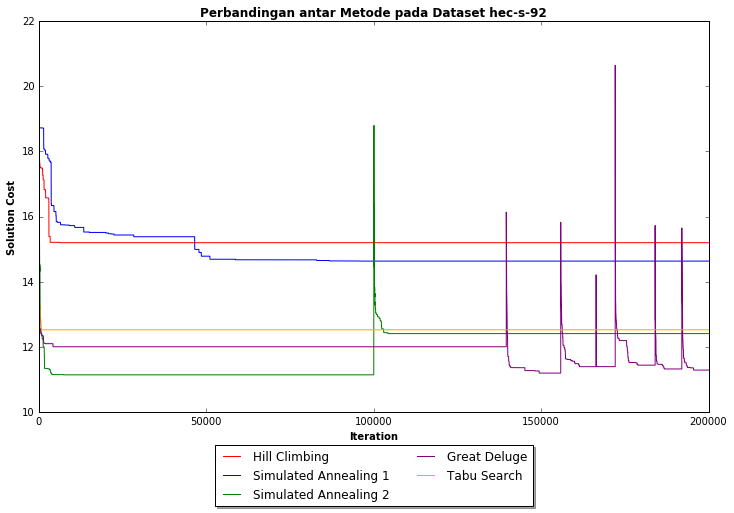

<Figure size 1008x720 with 0 Axes>

In [32]:
fig, ax = plt.subplots(figsize=(12, 7))
ax = plt.subplot(111)
ax.plot(np.array(period1), np.array(score_cost1), color='red', label = 'Hill Climbing')
ax.plot(np.array(period1), np.array(score_cost2), color='blue', label = 'Simulated Annealing 1')
ax.plot(np.array(period1), np.array(score_cost3), color='green', label = 'Simulated Annealing 2')
ax.plot(np.array(period1), np.array(score_cost4), color='purple', label = 'Great Deluge')
ax.plot(np.array(period1), np.array(score_cost5), color='orange', label = 'Tabu Search')
#ax.plot(np.array(period1), np.array(score_cost6), color='cyan', label = 'Artificial Bee Colony')
plt.xlabel('Iteration', fontweight='bold')
plt.ylabel('Solution Cost', fontweight='bold')
plt.title('Perbandingan antar Metode pada Dataset {}'.format(dataset), fontweight='bold')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),shadow=True, ncol=2)
plt.figure(figsize=(14,10))
plt.show()

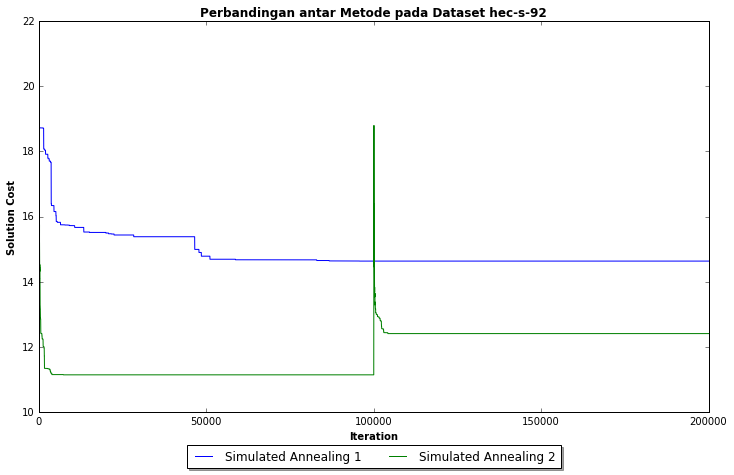

<Figure size 1008x720 with 0 Axes>

In [33]:
fig, ax = plt.subplots(figsize=(12, 7))
ax = plt.subplot(111)
ax.plot(np.array(period1), np.array(score_cost2), color='blue', label = 'Simulated Annealing 1')
ax.plot(np.array(period1), np.array(score_cost3), color='green', label = 'Simulated Annealing 2')
plt.xlabel('Iteration', fontweight='bold')
plt.ylabel('Solution Cost', fontweight='bold')
plt.title('Perbandingan antar Metode pada Dataset {}'.format(dataset), fontweight='bold')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),shadow=True, ncol=2)
plt.figure(figsize=(14,10))
plt.show()

# Referensi
***

[1] Simulated Annealing: Advances, Applications and Hybridizations oleh Marcos Sales Guerra Tsuzuki<br>
[2] [Geeksforgeeeks Hill Climbing](https://www.geeksforgeeks.org/introduction-hill-climbing-artificial-intelligence/)